In [5]:
import os
import pandas as pd
import numpy as np
import random
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

# **Import and explore the data**

In [6]:
base_dir = '/kaggle/input/fruits/fruits-360_dataset/fruits-360'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

## Distributions of number of samples across classes

In [165]:
cat_counts_train = pd.Series({
    os.path.basename(dir): len(files) for dir, subdir, files in os.walk(train_dir) if subdir == []
}).sort_index()

cat_counts_test = pd.Series({
    os.path.basename(dir): len(files) for dir, subdir, files in os.walk(test_dir) if subdir == []
}).sort_index()

print(f'Train: found {cat_counts_train.sum()} images belonging to {len(cat_counts_train)} clasees')
print(f'Test: found {cat_counts_test.sum()} images belonging to {len(cat_counts_test)} clasees')

Train: found 67692 images belonging to 131 clasees
Test: found 22688 images belonging to 131 clasees


In [166]:
fig1 = px.bar(cat_counts_train, labels={'index':'', 'value':''})

fig1.update_layout(
    xaxis={'showticklabels': True, 'tickfont':{'size': 5}},
    showlegend=False,
    title=f'<b>Distribution of class sizes - Train data',
    height=400,
)

fig1.add_hline(
    y=cat_counts_train.mean(),
    line_color='red',
    annotation_text='Mean',
    annotation_font_size=20,
    annotation_font_color="red"
)

fig2 = px.bar(cat_counts_test, labels={'index':'', 'value':''})

fig2.update_layout(
    xaxis={'showticklabels': True, 'tickfont':{'size': 5}},
    showlegend=False,
    title=f'<b>Distribution of class sizes - Test data',
    height=400,
)

fig2.add_hline(
    y=cat_counts_test.mean(),
    line_color='red',
    annotation_text='Mean',
    annotation_font_size=20,
    annotation_font_color="red"
    
)

fig1.show()
fig2.show()

## t-tests for difference in shares of class in train and test data

In [60]:
shares_train = cat_counts_train/cat_counts_train.sum()
shares_test = cat_counts_test/cat_counts_test.sum()

var_adj_train = shares_train * (1 - shares_train)/cat_counts_train.sum()
var_adj_test = shares_test * (1 - shares_test)/cat_counts_test.sum()

share_diffs = shares_train - shares_test
t_stats = (share_diffs/np.sqrt(var_adj_train + var_adj_test)).sort_values(key=lambda x: np.abs(x), ascending=False)

pd.DataFrame(t_stats, columns=['t_stat']).head(10)

,t_stat
Onion Red Peeled,-0.410088
Apple Red Yellow 2,0.364875
Tomato Maroon,-0.308824
Chestnut,-0.153011
Pomelo Sweetie,-0.153011
Watermelon,0.152453
Salak,0.151975
Pineapple Mini,0.151886
Walnut,-0.146535
Pear Kaiser,-0.124792


## Summary:

* We are dealing with 
* Overall, the dataset is fairly balanced; the distribution of class sizes is close to uniform
* Although there are some outliers among the categories, none of them is too far from the mean (at most twice larger or twice smaller than the average category)
* The shares of classes in train and in test data are also consistent: none of the t-tests for differences in means shows significance

# Random sample

Found 67692 images belonging to 131 classes.
Image size: (100, 100, 3)


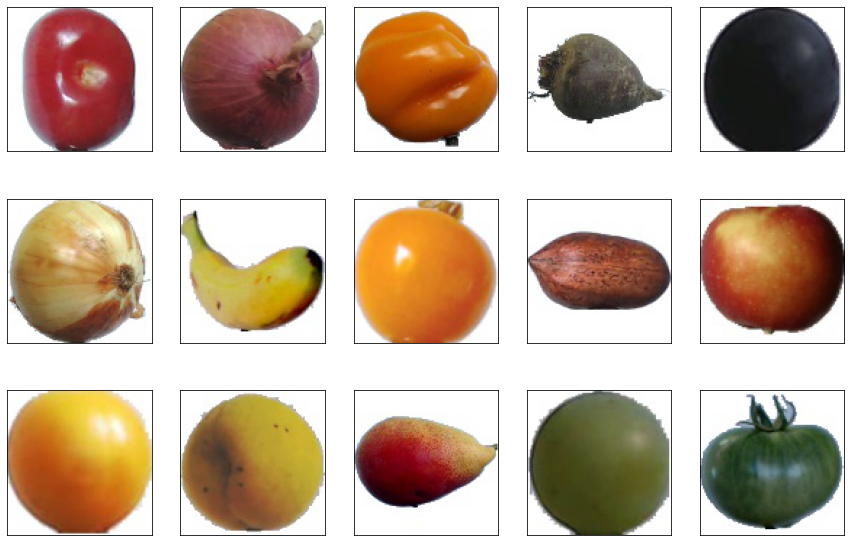

In [61]:
datagen_temp = ImageDataGenerator().flow_from_directory(
    train_dir, 
    target_size=(100, 100),
    batch_size=15,
    class_mode=None
)

plt.figure(figsize=(15, 10))
for batch in datagen_temp:
    
    print(f'Image size: {batch[0].shape}')
    
    for i, img in enumerate(batch):
        plt.subplot(3, 5, i + 1)
        plt.imshow(img/255)
        plt.tick_params(
            left = False,
            right = False,
            labelleft = False ,
            labelbottom = False,
            bottom = False
        )
    plt.show()
    
    break

In [62]:
def plot_sample_from_class(class_name, rows=3):
    
    path_class = os.path.join(train_dir, class_name)
    class_imgs = os.listdir(path_class)
    random.shuffle(class_imgs)

    plt.figure(figsize=(15, 3*rows), facecolor='white')

    for i, path_img in enumerate(class_imgs[:rows*5]):

        img = plt.imread(os.path.join(path_class, path_img))
        plt.subplot(rows, 5, i + 1)
        plt.imshow(img)
        plt.tick_params(
            left = False,
            right = False,
            labelleft = False ,
            labelbottom = False,
            bottom = False
        )
    plt.suptitle(f'Samples from class "{class_name}"', fontsize=20)
    plt.show()

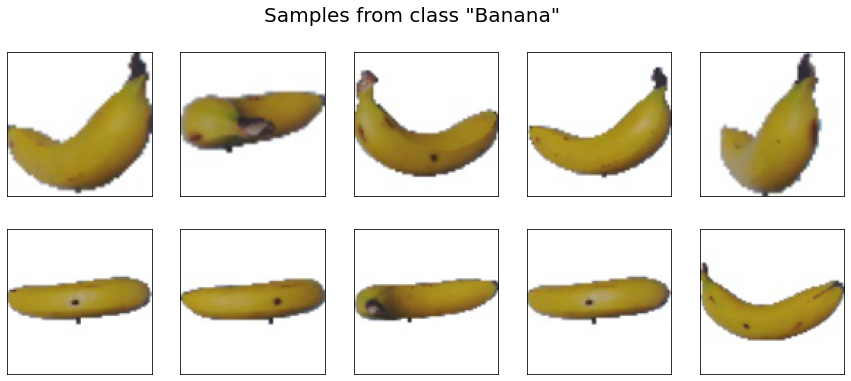

In [63]:
plot_sample_from_class('Banana', rows=2)

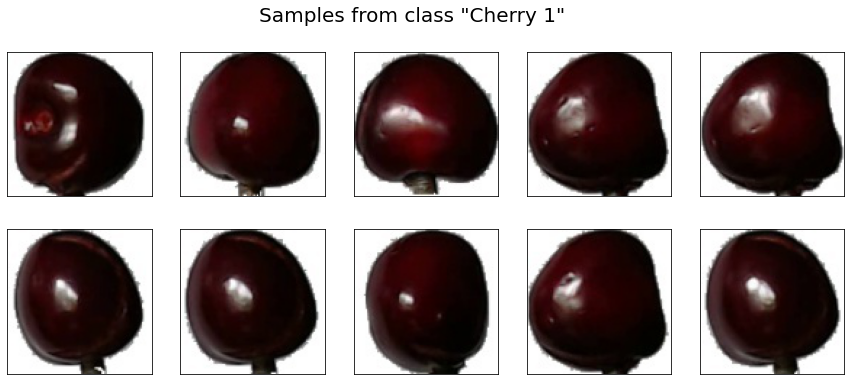

In [64]:
plot_sample_from_class('Cherry 1', rows=2)

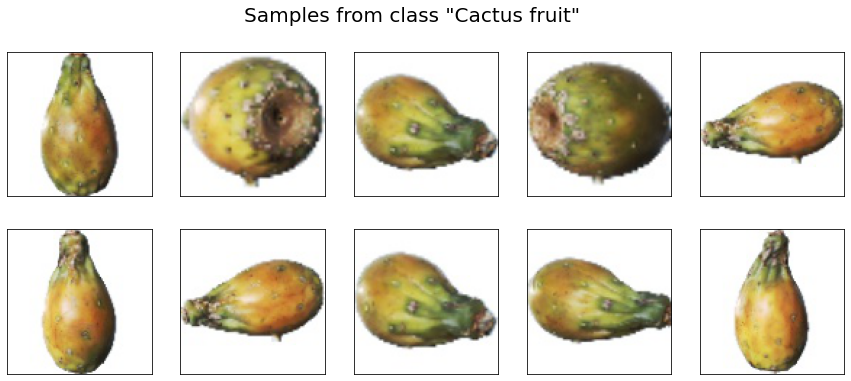

In [65]:
plot_sample_from_class('Cactus fruit', rows=2)

* We are dealing with pre-proceesed 100x100 images of fruits
* The background is removed, and the position of the fruit is always the same -- it's centered and occupies most of the image
* However, the **orientaion of the fruit may change**

# Notes on potential data augmentations:

* **Mirror flips** are unlikely to produce completely new samples 
* **Rotations**, however are - for example there are seemingly no "vertical" bananas, and no "diagonal" the cactus fruits
* **Affine transforms** (changing the shape), **shifts/crops** (spoiling centering) and **adding noise** (changing the texture) are, **probably, undesirable** - they may produce the images that are too far from the ones that the model will see in test. 

To sum up, data augmentation is unlikely to produce large improvements -- the dataset is rather large (~500 train samples per class), and the samples within one class are very homogenous, so overfitting doesn't look like a major threat.

Moreover, according to the creators of the dataset, each class contains only images of one exact exemplar. Thus, in some sense overfitting of the model to certain "scars" and imperfections of the fruits, while being bad for generalizability, will likely be a positive thing for test performance. 

Still, rotations (especially proportional to 90°) may turn out useful, since they will produce images simmilar in overall characteristics yet different from the originals.

# Baseline model: CNN with 4 convolution layers

We implement first a simple baseline mode, similar to ones that the authors use in the original paper:

* 4 **Convolution 3x3 + ReLU + Maxpooling 2x2** layers with increasing numbers of output channels

* 2 hidden **FC + ReLU** layers and an output layer with softmax activation (since we have multiple classes)

Model is trained using **cross-entropy** loss over 30 epochs on batches of 100 samples (so ~670 steps per epoch to cover the whole data). No early stopping is used, since it's a diagnostic run, and we migh want to know the full learning dynamics

### Regularization & data augmentations

First, we train plain mode without data augmentations or dropouts.
Then, we train same exact architecure but with the following regularizations and data augmentations:

* Dropout layer before FC
* Random rotations, proportional to 90° degrees (not to loose parts of large fruits in non-orthogonal rotations)
* Mirror flips (both horizontal and vertical)

### I. Baseline

In [4]:
# Rescale the images to [0, 1]
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir, 
    target_size=(100, 100),
    batch_size=100,
    class_mode='categorical'
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, 
    target_size=(100, 100),
    batch_size=100,
    class_mode='categorical'
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [36]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu',input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(131, activation='softmax'))

In [37]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['acc']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)        

In [ ]:
# csv_logger=CSVLogger('cnn-4-baseline.log',separator=",",append=False)

# history = model.fit(
#       train_generator,
#       steps_per_epoch=677,
#       epochs=30,
#       validation_data=test_generator,
#       validation_steps=227,
#       callbacks=[csv_logger,]
# )

# model.save('cnn-4-baseline')

In [9]:
history = pd.read_csv('cnn-4-baseline.log')

### II. Dropout + data augmentations

In [28]:
def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-2, -1, 0, 1]))

train_generator_aug = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=orthogonal_rot,
    horizontal_flip="True",
    fill_mode="nearest",
).flow_from_directory(
    train_dir, 
    target_size=(100, 100),
    batch_size=100,
    class_mode='categorical',
)

Found 67692 images belonging to 131 classes.


In [30]:
model_aug = models.Sequential()

model_aug.add(layers.Conv2D(16, (3, 3), activation='relu',input_shape=(100, 100, 3)))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

# Add dropout layer
model_aug.add(layers.Flatten())
model_aug.add(layers.Dropout(0.2))

model_aug.add(layers.Dense(1024, activation='relu'))

model_aug.add(layers.Dense(256, activation='relu'))

model_aug.add(layers.Dense(131, activation='softmax'))

In [31]:
model_aug.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['acc']
)
model_aug.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         7

In [ ]:
# csv_logger=CSVLogger('cnn-4-dropout+aug.log',separator=",",append=False)

# history_aug = model_aug.fit(
#       train_generator_aug,
#       steps_per_epoch=677,
#       epochs=30,
#       validation_data=test_generator,
#       validation_steps=227,
#       callbacks=[csv_logger,]
# )

# model_aug.save('cnn-4-dropout+aug')

In [38]:
history_aug = pd.read_csv('cnn-4-dropout+aug.log')

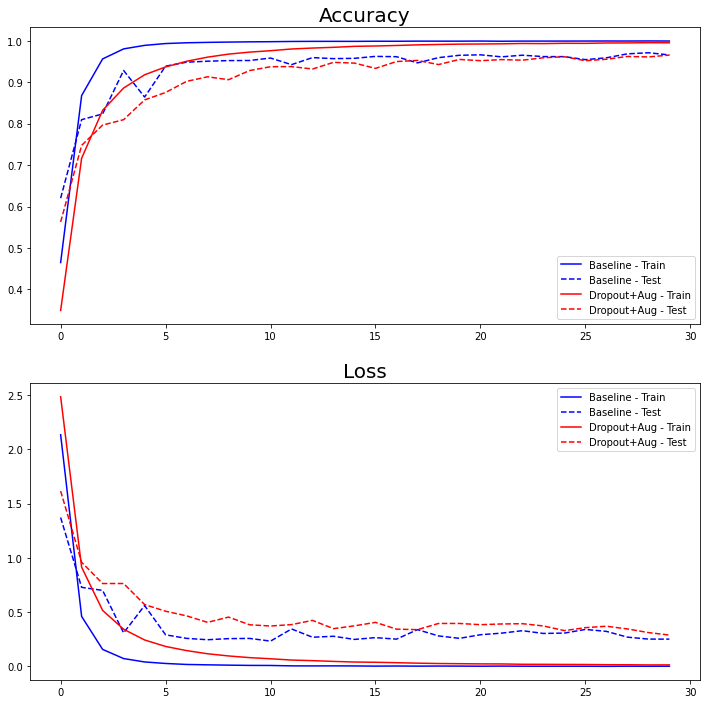

In [57]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

acc_aug = history_aug['acc']
val_acc_aug = history_aug['val_acc']
loss_aug = history_aug['loss']
val_loss_aug = history_aug['val_loss']

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))

ax1.plot(epochs, acc, label='Baseline - Train', color = 'b')
ax1.plot(epochs, val_acc, '--', label='Baseline - Test', color='b')
ax1.plot(epochs, acc_aug, label='Dropout+Aug - Train', color='red')
ax1.plot(epochs, val_acc_aug, '--', label='Dropout+Aug - Test', color='red')
ax1.set_title('Accuracy', fontsize=20)
ax1.legend()

ax2.plot(epochs, loss, label='Baseline - Train', color = 'b')
ax2.plot(epochs, val_loss, '--', label='Baseline - Test', color='b')
ax2.plot(epochs, loss_aug, label='Dropout+Aug - Train', color='red')
ax2.plot(epochs, val_loss_aug, '--', label='Dropout+Aug - Test', color='red')
ax2.set_title('Loss', fontsize=20)
ax2.legend()

plt.show()

### Evaluation

Overall, both models show strong performance both in and out of sample, reaching > 96.5% accuracy on test set. There are no major differences in the final results (loss seems to be a little bit lower in baseline, but the difference is minor). However, the learning curve of with model with dropout and data augmentations seems more smooth and stable. Thus, for more complex models it **might be useful to use augmentations**.

Let's look at the test samples that the model fails to classify properly:

In [7]:
model_aug = load_model('cnn-4-dropout+aug')

Found 22688 images belonging to 131 classes.


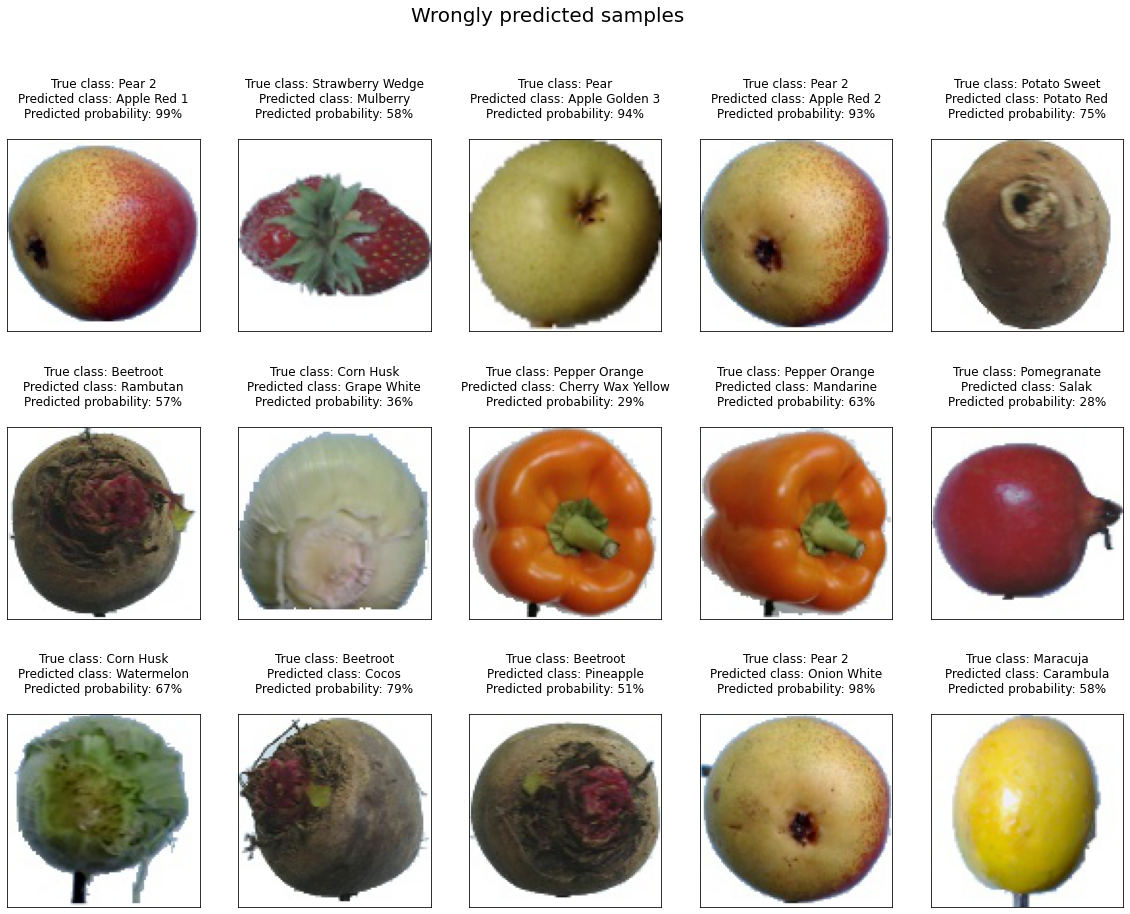

In [130]:
gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, 
    target_size=(100, 100),
    batch_size=100,
    class_mode='categorical'
)
class_names = {v: k for k, v in gen.class_indices.items()}

wrong_predictions = 0

plt.figure(figsize=(20, 15), facecolor='white')

while wrong_predictions < 15:
    for batch in gen:
        pred = model_aug.predict(batch[0])
        true = batch[1]
        for i in range(len(batch[0])):
            if np.argmax(pred[i]) != np.argmax(true[i]):
                plt.subplot(3, 5, wrong_predictions + 1)
                plt.imshow(batch[0][i])
                plt.tick_params(
                    left = False,
                    right = False,
                    labelleft = False ,
                    labelbottom = False,
                    bottom = False
                )
                plt.title(f"""
True class: {class_names[np.argmax(true[i])]}
Predicted class: {class_names[np.argmax(pred[i])]}
Predicted probability: {int(np.max(pred[i]*100))}%
                """)
                
                wrong_predictions += 1
                if wrong_predictions >= 15:
                    break
        break
    
plt.suptitle(f'Wrongly predicted samples', fontsize=20)
plt.show()

In [9]:
gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, 
    target_size=(100, 100),
    batch_size=100,
    class_mode='categorical'
)
class_names = {v: k for k, v in gen.class_indices.items()}

wrong_predictions = {}
steps = 0

for batch in gen:
    if steps == 227:
        break
    pred = model_aug.predict(batch[0])
    true = batch[1]
    for i in range(len(batch[0])):
        if np.argmax(pred[i]) != np.argmax(true[i]):
            true_class = class_names[np.argmax(true[i])]
            wrong_predictions[true_class] = wrong_predictions.get(true_class, 0) + 1
    steps += 1

Found 22688 images belonging to 131 classes.


In [13]:
# pd.DataFrame(wrong_predictions).to_csv('wrong_predictions.csv')
wrong_predictions = pd.read_csv('wrong_predictions.csv')
wrong_predictions.columns = ['Class', 'Number of errors']

In [14]:
fig = px.bar(
    wrong_predictions.sort_values(by='Number of errors', ascending=False),
    x='Class',
    y='Number of errors'
)

fig.update_layout(title='<b>Distribution of errors between classes')
fig.show()

Though we have >100 classes, the majority of the errors seems to come from a small subset of classes. At this poin it's not quite clear, how to address this, because there might be several problems. For example:

* `Pear 2` seems to be the most difficult class to predict. In the random sample of errors we see two of those being confused with apples -- they are indeed diffuclt to distinguish, so maybe we just need a stronger and more complex model

* Also `Pepper orange` being twice confused with other orange fruits (mandarine and orange cherry). Obviously, color seems to play a role, so another potential regularization could be changing brightness/contrast (or even converting to grayscale) to make model pay more attention to form